In [418]:
#import keras essentials and stuff
import tensorflow as tf
from keras.layers import Dropout
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Normalization

import matplotlib.pyplot as plt
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


# Making a neural net
---
the neural net takes two input variables for now 
the genre(as one bit encoded) and a historical event (i.e second world war, vietnam war, etc).

genres are one hot encoded as wel as the historical event.
this is split per columns and each genre and historical event gets it's own column.

this spits out a release year based on genre

# Preprocessing
---
preprocessing the data is necessary to make it suitable for the neural network

In [419]:
# import neccessary stuff 
#run this from the datascience-films folder
import pandas as pd 
import numpy as np
from pathlib import Path
# ignore some warnings, not pressing to fix these issues, more annoying to show these
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

RESOURCE_PATH = Path('../cleaned_data')

df = pd.read_csv(RESOURCE_PATH / 'final_data_movies.csv',sep=',')
#fill null values of movies which do not have a historical event.
# df= df.dropna()
df['years_after_event'] = df['years_after_event'].fillna(0)
df = df[df['numVotes'] < 1000]
# df = df.drop_duplicates(subset=['primaryTitle'])

In [420]:
df['numVotes'] = df['numVotes'].fillna(0)
#lastly pop our target we want
target = df[['years_after_event','averageRating','numVotes']]
target.averageRating =  target.averageRating.fillna(1)
target['numVotes'] = target['numVotes'].fillna(0)
target['numVotes'] = target['numVotes'].astype(np.int64)
target['averageRating'] = target['averageRating'].fillna(1)
target['averageRating'] = target['averageRating'].astype(np.int64)

target

,years_after_event,averageRating,numVotes
1,0.0,7,16
3,0.0,6,48
4,0.0,7,7
6,0.0,6,48
7,0.0,7,189
...,...,...,...
1657,0.0,7,189
1660,0.0,6,162
1662,0.0,7,8
1663,0.0,7,8


In [421]:
# split genres per genre and create column per genre
unique_genres = pd.unique(df["genres"].str.split(",", expand=True).stack())
df = df.join(df.pop('genres').str.get_dummies(sep=',').astype(bool))
df = df.join(df.pop('historical_event').str.join('').str.get_dummies().astype(bool))

In [422]:
# get numeric features and set as input
numeric_feature_names = list(unique_genres)
numeric_feature_names.append('Vietnam War')
numeric_feature_names.append('Second World War')
numeric_features = df[numeric_feature_names]
numeric_features

,Drama,Romance,Short,Documentary,Action,Fantasy,Sci-Fi,Biography,Crime,Mystery,...,Animation,Horror,(no genres listed),History,Adventure,Musical,Reality-TV,Family,Vietnam War,Second World War
1,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1660,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1662,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1663,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [423]:
from sklearn.model_selection import train_test_split

# splits the training and test data set in 65% : 35%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(numeric_features, target, test_size = 0.40, random_state=20)
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(522, 24)
(522, 3)
(348, 24)
(348, 3)


# Neural net
---
this part is for initializing the neural net

In [424]:
# convert to the features to a tensor

X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int64)




In [425]:
class Neural_Net():

    def __init__(self):
        """
        Set up the neural net. 
        - input nodes: 
            - historical event label
            - genres
            
        - output node 
            - years after a major event specified to bring out the movie
            - average predicted rating
            - number of ratings.
        """
        opt = tf.keras.optimizers.SGD(learning_rate=0.000001, momentum= 0.90)

        self.model = Sequential([
            Dense(10, input_shape=[24,], kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.LeakyReLU(alpha=0.05),
            Dropout(0.3),
            Dense(1600, kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.LeakyReLU(alpha=0.10),
            Dropout(0.3),
            Dense(40, kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.LeakyReLU(alpha=0.05),
            Dropout(0.3),
            Dense(3, kernel_regularizer=regularizers.l2(0.01))
        ])

        self.model.compile(
            optimizer= opt,
            loss='mean_squared_error'
            , metrics= ['accuracy'
                        ]
            )

    def train(self, epochs: int):
        self.history = self.model.fit(
            X_train,
            Y_train,
            epochs=epochs,
            batch_size=16,
            steps_per_epoch=10,
            validation_split = 0.45,
            verbose=1
            )

    def evaluate(self):
        self.results = self.model.evaluate(X_test, Y_test, batch_size=25)
        print(f"results: {self.results}")

    
    def predict(self, input: tf.Tensor):
        predictions = self.model.predict(input)
        for prediction in predictions:
            print(f"prediction: {prediction}")


    def convert_to_input(self, list_of_inputs: list):
        tmp_df = pd.DataFrame(columns=numeric_feature_names)
        for index,sample in enumerate(list_of_inputs):
            tmp_df = tmp_df.append(pd.Series(), ignore_index=True)
            for col_index, _ in enumerate(tmp_df.columns):
                for genre in sample[0]:
                    tmp_df.loc[index, tmp_df.columns.values == genre] = True
                if col_index == 23:
                    for event in sample[1]:
                        tmp_df.loc[index, tmp_df.columns.values == event] = True
        tmp_df = tmp_df.fillna(False)
        return tf.convert_to_tensor(tmp_df)




    def save(self, path):
        """
        save the trained weights.
        """
        self.model.save_weights(path)
    
    def load(self, path: str):
        """
        load the weights of the model
        """
        self.model.load_weights(path)

    def plot_cost(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.plot(epochs, loss, 'bo', label='Training_loss')
        plt.plot(epochs,val_loss, 'bo', color='g', label='Val_loss')
        plt.title('Training and validation loss')
        plt.legend()

    def plot_acc(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        epochs = range(1, len(loss) + 1)

        plt.plot(epochs, val_acc, 'y', label='Validation acc')
        plt.plot(epochs, acc, 'b', label=' acc')
        plt.title('Training and validation accuracy')
        plt.legend()


model = Neural_Net()

In [426]:
#train the model
model.train(800)

Epoch 1/800
10/10 [==============================] - 0s 14ms/step - loss: 19464.0840 - accuracy: 0.4500 - val_loss: 22757.1426 - val_accuracy: 0.4170
Epoch 2/800
10/10 [==============================] - 0s 3ms/step - loss: 15825.6807 - accuracy: 0.4403 - val_loss: 22755.4219 - val_accuracy: 0.5106
Epoch 3/800
10/10 [==============================] - 0s 3ms/step - loss: 26420.3398 - accuracy: 0.6125 - val_loss: 22753.2383 - val_accuracy: 0.6340
Epoch 4/800
10/10 [==============================] - 0s 3ms/step - loss: 16660.3203 - accuracy: 0.7296 - val_loss: 22750.8770 - val_accuracy: 0.7787
Epoch 5/800
10/10 [==============================] - 0s 4ms/step - loss: 15851.7471 - accuracy: 0.8000 - val_loss: 22748.5332 - val_accuracy: 0.8979
Epoch 6/800
10/10 [==============================] - 0s 4ms/step - loss: 21332.1348 - accuracy: 0.8491 - val_loss: 22746.1270 - val_accuracy: 0.8979
Epoch 7/800
10/10 [==============================] - 0s 4ms/step - loss: 16849.5781 - accuracy: 0.8687 - 

In [432]:
# evaluate the model
model.evaluate()


14/14 [==============================] - 0s 1ms/step - loss: 5175.5620 - accuracy: 0.9224
results: [5175.56201171875, 0.9224137663841248]


In [434]:
#save the model:
model.save('Model_save_sgd_test')

In [1250]:
#load the model
model.load('Model_save_sgd')


Two checkpoint references resolved to different objects (<keras.layers.core.dense.Dense object at 0x7f9cf15eb220> and <keras.layers.core.dropout.Dropout object at 0x7f9cf2159e50>).

Two checkpoint references resolved to different objects (<keras.layers.core.dense.Dense object at 0x7f9cf1bdbfd0> and <keras.layers.core.dropout.Dropout object at 0x7f9cf1bdbe20>).


ValueError: Shapes (20,) and (27,) are incompatible

In [435]:
#predict using the model
use_samples = [
    [['War',"Documentary"],["Vietnam War"]],
    [["War"], ["Second World War"]],
    [["Documentary"],[]],
    [["Action"],[]],
    [["War"],[]],
    [["Sport"],[]]
    ]
new_data = model.convert_to_input(use_samples)
model.predict(new_data)

/tmp/ipykernel_2691696/3591159278.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_df = tmp_df.append(pd.Series(), ignore_index=True)
/tmp/ipykernel_2691696/3591159278.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp_df = tmp_df.append(pd.Series(), ignore_index=True)
/tmp/ipykernel_2691696/3591159278.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_df = tmp_df.append(pd.Series(), ignore_index=True)
/tmp/ipykernel_2691696/3591159278.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp_df = tmp_df.append(pd.Series(), ignore_index=True)
/tmp/ipykernel_26916

prediction: [ 1.0231777  1.2949967 72.67315  ]
prediction: [  3.9034665   4.531714  311.65408  ]
prediction: [ 0.6415901   0.87088466 40.93356   ]
prediction: [ 0.5477355  0.7657796 33.485916 ]
prediction: [  7.4996614   8.57957   610.54816  ]
prediction: [ 0.6325172  0.8571807 39.294556 ]


/tmp/ipykernel_2691696/3591159278.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_df = tmp_df.append(pd.Series(), ignore_index=True)
/tmp/ipykernel_2691696/3591159278.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp_df = tmp_df.append(pd.Series(), ignore_index=True)


/tmp/ipykernel_2691696/3724348750.py:94: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,val_loss, 'bo', color='g', label='Val_loss')


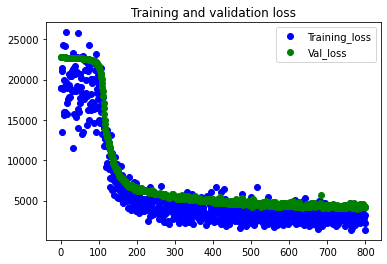

In [417]:
model.plot_cost()

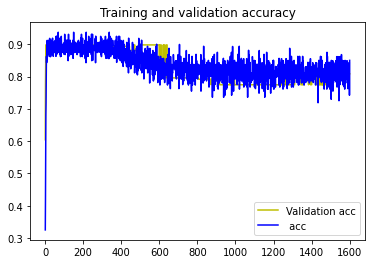

In [406]:
model.plot_acc()

# Next steps
---

whoop